In [1]:
import random, os
import numpy as np
import torch
from fastai.vision.all import *

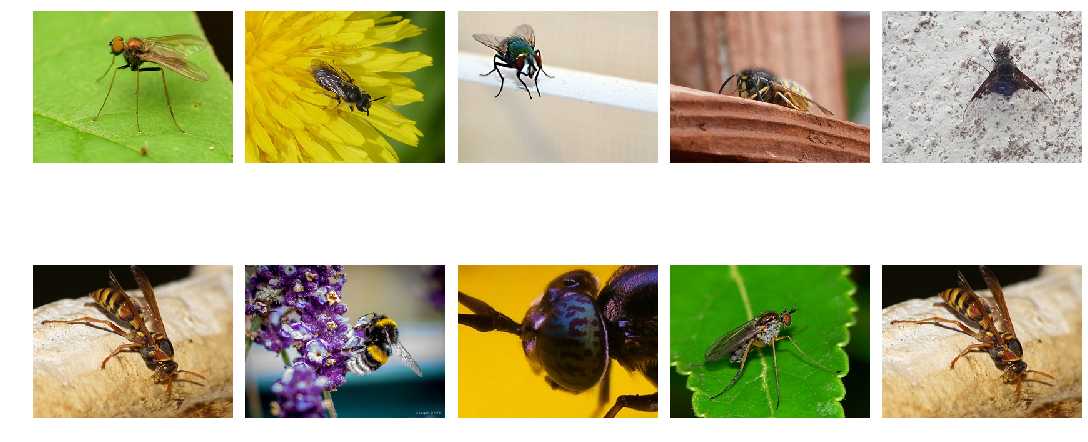

In [2]:
#Load some pictures randomly for checking effect
files = glob.glob('kaggle_bee_vs_wasp/*/*.jpg')
f, plots = plt.subplots(2, 5, sharex='col', sharey='row', figsize=(15, 7),  constrained_layout=True)
im_plot = []

for j in files:
    im = Image.open(np.random.choice(files))
    if im.size == (320, 245):
        im_plot.append(im)
    if len(im_plot)==11:
        break


for i in range(10):
    plots[i // 5, i % 5].axis('off')
    plots[i // 5, i % 5].imshow(im_plot[i])

In [3]:
#Set seed
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()

In [4]:
path = Path('kaggle_bee_vs_wasp'); 

In [5]:
#Load data and pick sample of data
df = pd.read_csv(path/'labels.csv', index_col=0);
df['path'] = df['path'].apply(lambda x:x.replace('\\', '/'))

def sample(df, p):
    df_train = df[(df.is_validation==0) & (df.is_final_validation==0)]
    df_valid = df[(df.is_validation==1) & (df.is_final_validation==0)]
    df_final_valid = df[(df.is_validation==0) & (df.is_final_validation==1)]
    df_train = df_train.iloc[0:int(len(df_train)*p), :]
    df_valid = df_valid.iloc[0:int(len(df_valid)*p), :]
    df_final_valid = df_final_valid.iloc[0:int(len(df_final_valid)*p), :]
    return pd.concat([df_train, df_valid, df_final_valid])

def label_sample(df, p):
    df_bee = sample(df[df.label == 'bee'], p)
    df_insect = sample(df[df.label == 'insect'], p)
    df_other = sample(df[df.label == 'other'], p)
    df_wasp = sample(df[df.label == 'wasp'], p)
    return pd.concat([df_bee, df_insect, df_other, df_wasp])
    
df = label_sample(df, 0.04)

In [6]:
df.shape

(453, 9)

In [7]:
dls = ImageDataLoaders.from_df(df, path, item_tfms=Resize(412),seed=0, valid_pct=0.2,
                              bs=32, num_workers=0, valid_col='is_validation', label_col="label")

['bee', 'insect', 'other', 'wasp']
4


(385, 68)

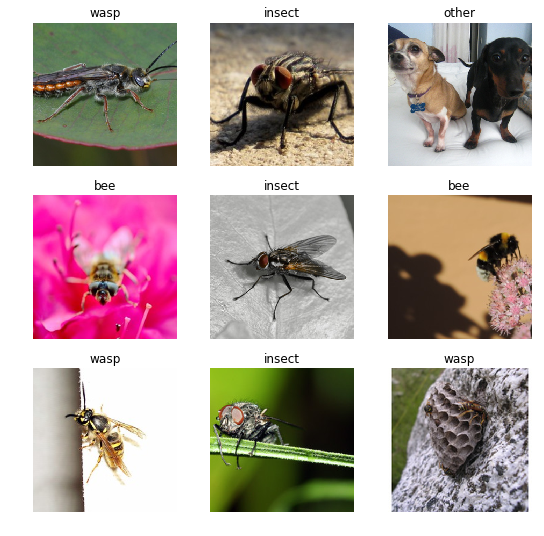

In [8]:
dls.show_batch()
print(dls.vocab)
print(dls.c)
len(dls.train_ds), len(dls.valid_ds)

In [9]:
#Load pretrained models: This time, we choose resnet34 model for checking
learn = cnn_learner(dls, resnet50, metrics=[error_rate, accuracy], model_dir="/tmp/model/").to_fp16()

c:\users\45141\appdata\local\programs\python\python37\lib\site-packages\fastai\learner.py:53: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


SuggestedLRs(lr_min=0.006918309628963471, lr_steep=0.00015848931798245758)

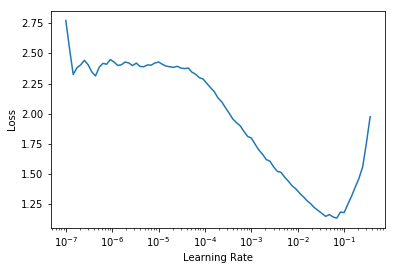

In [10]:
#Find learning rate suggestions
learn.lr_find()

In [16]:
#Model training
learn.unfreeze()
#learn.fit_one_cycle(50, lr_max=slice(2e-7, 1e-4), cbs=EarlyStoppingCallback(patience=3))
learn.fit_one_cycle(50, lr_max=slice(2e-7, 6e-3), cbs=EarlyStoppingCallback(patience=3))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.190167,0.574619,0.102941,0.897059,00:12
1,0.179982,0.458846,0.088235,0.911765,00:12
2,0.202577,0.415317,0.073529,0.926471,00:12
3,0.163388,0.453168,0.088235,0.911765,00:12
4,0.132637,0.476699,0.088235,0.911765,00:12
5,0.115172,0.392339,0.073529,0.926471,00:12
6,0.104763,0.458320,0.102941,0.897059,00:12
7,0.087633,0.473084,0.088235,0.911765,00:12
8,0.076017,0.711648,0.088235,0.911765,00:12


No improvement since epoch 5: early stopping


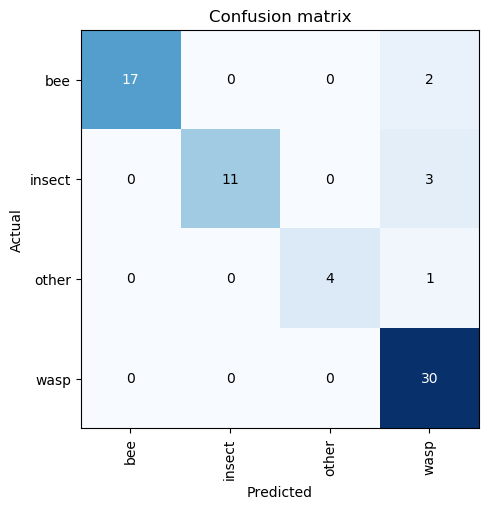

In [17]:
#Print the confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5), dpi=100)